# 深層学習ノートブック-9 MLPのコードをリファクタリング

DL_notebook-5から8までで実装してきた2層のMLPや誤差逆伝播コードをクラス化して整理する。  
各Layerをクラス化したのち、これらのクラスを用いてMLPのModel全体を表すクラスを作成する。  

参考：  
* [Udemy講座：「①米国AI開発者がやさしく教える深層学習超入門第一弾【Pythonで実践】」](https://www.udemy.com/course/deeplearning1/learn/lecture/40143418)

### ■ 考え方
MLPの登場人物（計算過程）をおおまかに分解すると、  
入力層（特徴量X）、隠れ層の線形変換部、隠れ層の活性化関数適用部、出力層の線形変換部、損失関数の計算に分けられる。  
※出力層の活性化関数は恒等関数と考えるので割愛。  

入力層は特徴量Xがあるだけなので、クラス化する必要はない。  
よって、隠れ層の線形変換部、隠れ層の活性化関数適用部、出力層の線形変換部、損失関数の計算をクラス化すれば見やすそう。   
さらに隠れ層の線形変換部と出力層の線形変換部はやっている計算は同じなので、より抽象化して”線形変換の計算を行うクラス”としてまとめられる。   

また、線形変換、隠れ層の活性化関数、損失関数の計算では順伝播と逆伝播の2方向の計算が行われるので、  
これらのクラスにはforwardメソッド、backwardメソッドを用意する。  

上記のように定義したクラスを用いてMLPのModel全体を表すクラスを作成する。  

### ■ ざっくりとしたクラス設計
* Linearクラス：　隠れ層・出力層の入力側（線形変換部）に相当
  * 線形変換への入力数（前の層の出力数）、出力数（隠れ層or出力層のノード数）はコンストラクタで受け取る。
  * forward,backwardメソッドを実装。
    * forwardの引数は前の層からの出力、backwardの引数はforwardの出力(=Z)  
      (”逆伝播”なので、線形変換の逆方向に計算する。なので、backwardの引数はforwardの出力になる。)  
  * パラメタW,Bはこのクラスのコンストラクタおよびforwardメソッドの引数として受け取るのではなく、  
    __init__の中で生成・定義しておく。パラメタは入力として隠れ層へ渡されるのではなく、隠れ層で”持っている”ため。    
    こうしておくことで呼び出し側でパラメタを都度生成する必要がなくなる。
* ReLUクラス：　隠れ層の出力側(活性化関数適用部)に相当
  * forward,backwardメソッドを実装。backwardではZの勾配を求める。

* SoftmaxCrossEntoropyクラス：　最終出力に対する損失関数の計算に相当。出力層の活性化関数は恒等関数とみなす。  
  * forward,backwardメソッドを実装。backwardでは予測値$\hat{Y}=\textbf{Z}^{[2]}$の勾配を求める。
* Modelクラス： MLPのプロセス全体を表すクラス
  * 隠れ層、出力層、損失関数の各計算に相当するインスタンスを生成する。
  * 一連の計算を実行するためのforward,backwardメソッドを実装。
  * 勾配をリセットするためのzero_gradメソッド、パラメータを更新するためのstepメソッドを用意する。

### ■ ポイント
* 各層のある時点の計算結果の勾配は常に（順伝播でいう）一つ先の計算結果の勾配で表わされる  
  例）X,W,Bの勾配はZの勾配で表わされる。Zの勾配はその後のAの勾配で表わされる。

In [2]:
import torch
import torch.nn.functional as F  #pytorchの便利関数はFでimportすることが多い。
import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# python debugerをインポート
import pdb

## ○ 各Layerのクラスを実装

In [40]:
# 隠れ層・出力層の入力側に相当するクラス
class Linear:
    def __init__(self, n_input, n_output) -> None:
        self.W = torch.randn((n_output, n_input)) * torch.sqrt(torch.tensor(2./n_input))
        self.W.requires_grad = False
        self.B = torch.zeros(size=(1, n_output), requires_grad=False) # 1 x 出力

    def forward(self, X): # Xには特徴量および隠れ層のAが入る。
        self.X = X # backwardでも計算に使いたいので、インスタンス変数に格納
        self.Z = X @ self.W.T + self.B 
        return self.Z
    
    def backward(self, Z):    
        self.W.grad_ = Z.grad_.T @ self.X
        self.B.grad_ = torch.sum(Z.grad_, dim=0)
        self.X.grad_ = Z.grad_ @ self.W
        return self.X.grad_ # Xおよび隠れ層のAの勾配を返す


# 隠れ層の出力側に相当するクラス
class ReLU:
    def forward(self, Z):
        self.Z = Z
        return torch.where(Z > 0 , Z, 0.) # Aを返す
    
    def backward(self, A):
        self.Z.grad_ = A.grad_ * ( self.Z > 0 ).float()
        return self.Z.grad_


# 損失関数を計算するクラス
class SoftmaxCrossEntoropy:
    def forward(self, X, y_true):
        max_val = X.max(dim=1, keepdim=True).values
        # 各要素のe^xを計算（これが分子になる）
        e_x = (X - max_val).exp()
        denominator = e_x.sum(dim=1, keepdim=True) + 1e-10
        self.softmax_out = e_x / denominator
        self.loss = - (y_true * torch.log(self.softmax_out + 1e-10)).sum() / y_true.shape[0]

        return self.loss, self.softmax_out 
    
    def backward(self, y_true): # 損失から最終出力の勾配を計算する。
        return (self.softmax_out - y_true) / y_true.shape[0] #softmax_outはyの予測値(Z2およびA2に同じ)
            

In [41]:
# 隠れ層１層の場合のMLP（スクラッチ）
class MlpModel:

    # コンストラクタでは特徴量数、隠れ層のノード数、出力層のノード数を受け取る。
    def __init__(self, n_features, hidden_units, output_units) -> None:
        self.Linear_1 = Linear(n_features, hidden_units)
        self.relu = ReLU()
        self.Linear_2 = Linear(hidden_units, output_units)
        self.loss_func = SoftmaxCrossEntoropy()
        

    def forward(self, X, y):
        self.X = X
        self.Z1 = self.Linear_1.forward(X)
        self.A1 = self.relu.forward(self.Z1)
        self.Z2 = self.Linear_2.forward(self.A1)
        # 出力層の活性化関数は恒等関数としているので、loss_funcの引数はA2ではなくZ2でOK
        self.loss, y_pred = self.loss_func.forward(self.Z2, y) 
        return self.loss , y_pred


    # 明にW,Bを計算していないが、メソッド内部で計算されてインスタンス変数として保持されていることに注意。
    def backward(self, y):
        self.Z2.grad_ = self.loss_func.backward(y) # lossが求まったということはひとつ前の出力Z2の勾配が求まる
        self.A1.grad_ = self.Linear_2.backward(self.Z2) # Z2の勾配が求まったということはひとつ前のA1の勾配が求まる。（同時にW2,B2の勾配も求まる）
        self.Z1.grad_ = self.relu.backward(self.A1) # A1の勾配が求まったということはひとつ前のZ1の勾配が求まる。
        self.X.grad_ = self.Linear_1.backward(self.Z1) # Z1の勾配が求まったということはひとつ前のXの勾配が求まる。（Xの勾配自体は格納しなくてもOk）


    # 勾配の初期化
    def zero_grad(self):
        self.Linear_1.W.grad_ = None
        self.Linear_1.B.grad_ = None
        self.Linear_2.W.grad_ = None
        self.Linear_2.B.grad_ = None


    # パラメタの更新
    def step(self, learning_rate):
        self.Linear_1.W -= learning_rate * self.Linear_1.W.grad_
        self.Linear_1.B -= learning_rate * self.Linear_1.B.grad_
        self.Linear_2.W -= learning_rate * self.Linear_2.W.grad_
        self.Linear_2.B -= learning_rate * self.Linear_2.B.grad_


## ■ 作成したクラスをMLPの学習ループへ組み込み

## 前準備
下記もリファクタリングの余地あるが、後程やる。

In [42]:
# 変数定義
learning_rate = 0.03
loss_log = []  #学習時の損失記録用のリスト

# データロード
dataset = datasets.load_digits()
feature_names = dataset['feature_names']
X = torch.tensor(dataset['data'], dtype=torch.float32)
target = torch.tensor(dataset['target'])

# shape確認
print(f'shape of X: {X.shape}')
print(X[1])
print('==========================')
print(f'shape of y_train: {target.shape}')
print(target)

# 目的変数のエンコーディング
y_true = F.one_hot(target, num_classes=10)
print(f'shape of y_true: {y_true.shape}')

# 学習データと検証データを8:2に分ける
X_train, X_val, y_train, y_val = train_test_split(X, y_true, test_size=0.2, random_state=42)

print(f'shape of train data: X_train:{X_train.shape}, y_train:{y_train.shape}')
print(f'shape of validation data: X_val:{X_val.shape}, y_val:{y_val.shape}')

# 学習データ・検証データの標準化。検証データの標準化には学習データの平均、標準偏差を使用することに注意。  
X_mean = X_train.mean()
X_std = X_train.std()
X_train = (X_train - X_mean) / X_std
X_val = (X_val - X_mean) / X_std

# データ数、特徴量数、隠れ層のノード数、最終的な出力数（ここではクラス数）を定義
m, n_features = X_train.shape
hidden_units = 30
output_units = 10


shape of X: torch.Size([1797, 64])
tensor([ 0.,  0.,  0., 12., 13.,  5.,  0.,  0.,  0.,  0.,  0., 11., 16.,  9.,
         0.,  0.,  0.,  0.,  3., 15., 16.,  6.,  0.,  0.,  0.,  7., 15., 16.,
        16.,  2.,  0.,  0.,  0.,  0.,  1., 16., 16.,  3.,  0.,  0.,  0.,  0.,
         1., 16., 16.,  6.,  0.,  0.,  0.,  0.,  1., 16., 16.,  6.,  0.,  0.,
         0.,  0.,  0., 11., 16., 10.,  0.,  0.])
shape of y_train: torch.Size([1797])
tensor([0, 1, 2,  ..., 8, 9, 8])
shape of y_true: torch.Size([1797, 10])
shape of train data: X_train:torch.Size([1437, 64]), y_train:torch.Size([1437, 10])
shape of validation data: X_val:torch.Size([360, 64]), y_val:torch.Size([360, 10])


In [43]:
# MLPクラスのインスタンス生成
model = MlpModel(n_features=n_features, hidden_units=hidden_units, output_units=output_units)

In [44]:
# ミニバッチのサイズ定義
batch_size = 32

# 全ミニバッチの数。ミニバッチサイズで割ったときの余りも考慮してプラス１
batch_num = len(y_train) // batch_size + 1

# 各epochごとの学習データ・検証データでの損失記録用
loss_per_epoch_train = []
loss_per_epoch_val = []

# 各epochごとの検証データでのAccuracy結果格納用
accuracy_log = {}


# for文で学習ループ作成
for epoch in range(30):
    # epochごとの損失を蓄積する用の変数
    running_loss = 0
    running_loss_val = 0

    # バッチごとの処理対象データ開始・終了インデックスを初期化
    batch_start_idx = 0
    batch_end_idx = batch_size

    # シャッフル後のindex
    shuffled_indices = np.random.permutation(len(y_train))

    # ミニバッチ勾配降下法
    for i in range(batch_num):
        #シャッフル後のindexからy,Xで同じ範囲を取り出しだしてミニバッチ作成
        batch_indices = shuffled_indices[batch_start_idx : batch_end_idx]
        y_train_batch = y_train[batch_indices, :]
        X_batch = X_train[batch_indices, :]

        # 順伝播の計算
        loss, y_pred = model.forward(X_batch, y_train_batch)
        # 逆伝播の計算
        model.backward(y_train_batch)
        # パラメタの更新
        model.step(learning_rate=learning_rate)
        # 勾配を初期化
        model.zero_grad()

        # 学習データに対するlossの計算・記録
        loss_log.append(loss.item())
        running_loss += loss.item()

        # batch開始・終了インデックスを更新。スライシングの仕様上、endがlen(y_train)を超えても問題ない。
        batch_start_idx += batch_size
        batch_end_idx += batch_size


    # 検証データに対する予測、lossの計算・記録（1epochにつき1回算出）
    loss_val, y_pred_val = model.forward(X_val, y_val)

    # epochの最終的な損失を出力。各バッチの損失の累積を全バッチ数で割って平均を求める
    loss_per_epoch_train.append(running_loss / batch_num)
    loss_per_epoch_val.append(loss_val.item())

    # 検証データに対するaccuracyの計算
    accuracy_log[epoch] = ( (torch.argmax(y_pred_val, dim=1) == y_val.argmax(dim=1)).sum() / len(y_val) ).item()

上記のように上手くオブジェクト指向で記述することにより、  
MLPの学習ループをシンプルに書ける。

In [45]:
accuracy_log

{0: 0.5972222089767456,
 1: 0.7805555462837219,
 2: 0.8611111044883728,
 3: 0.8888888955116272,
 4: 0.9027777910232544,
 5: 0.9138888716697693,
 6: 0.9194444417953491,
 7: 0.9277777671813965,
 8: 0.9333333373069763,
 9: 0.9444444179534912,
 10: 0.9444444179534912,
 11: 0.949999988079071,
 12: 0.9527778029441833,
 13: 0.9444444179534912,
 14: 0.9527778029441833,
 15: 0.949999988079071,
 16: 0.9527778029441833,
 17: 0.949999988079071,
 18: 0.9472222328186035,
 19: 0.949999988079071,
 20: 0.9444444179534912,
 21: 0.9527778029441833,
 22: 0.9527778029441833,
 23: 0.9555555582046509,
 24: 0.9583333134651184,
 25: 0.9527778029441833,
 26: 0.9583333134651184,
 27: 0.9583333134651184,
 28: 0.9611111283302307,
 29: 0.9583333134651184}

# ●学習曲線の描画
学習データと検証データでの損失の推移を確認してみる。

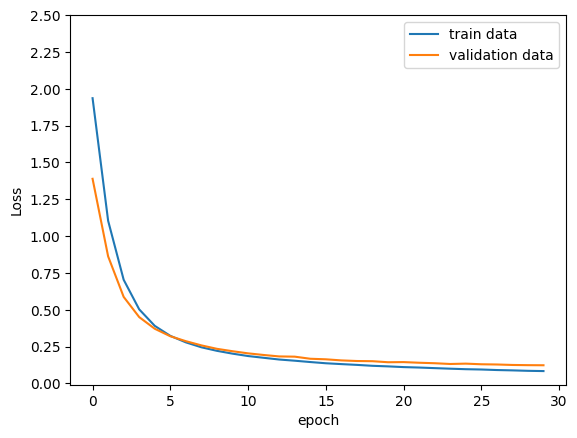

In [46]:
plt.plot(loss_per_epoch_train, label='train data')
plt.plot(loss_per_epoch_val, label='validation data')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.yticks(np.linspace(0.0, 2.5, 11))
plt.legend()